## Matching Stability Experiments

We consider first an example and check how stable is the matching.

First of all, we generate a distribution around three circles together with uniform noise on the background. For this we compute cycle affinities as in the article "Cycle Registration in Persistent Homology with Applications in Topological Bootstrap". All samples are drawn from the same distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.spatial.distance as dist

In [2]:
attributes = ["X_barcode", "S_barcode", "X_reps", "S_reps", "S_reps_im", "pm_matrix", "induced_matching"]
types_list = ["float", "float", "int", "int", "int", "int", "int", "int"]
EXECUTABLE_PATH = f"..\\x64\\Debug\\IBloFunMatchCPP.exe" # this is my particular path
def get_IBloFunMatch_subset(Dist_S, Dist_X, idS, attributes, types_list, output_dir):
    # Buffer files to write subsets and classes for communicating with C++ program 
    f_ind_sampl = output_dir + "\\indices_sample.out"
    f_dist_X = output_dir + "\\dist_X.out"
    f_dist_S = output_dir + "\\dist_S.out"
    output_data = {}
    # Compute distance matrices and save
    print(f"idS:{idS}")
    np.savetxt(f_ind_sampl, idS, fmt="%d", delimiter=" ", newline="\n")
    np.savetxt(f_dist_X, Dist_X, fmt="%.14e", delimiter=" ", newline="\n")
    np.savetxt(f_dist_S, Dist_S, fmt="%.14e", delimiter=" ", newline="\n")
    # Call IBloFunMatch C++ program (only for dimension 1 PH)
    ! {EXECUTABLE_PATH + " " + f_dist_S + " " + f_dist_X + " " + f_ind_sampl + " -d 2"}
    # Save barcodes and representatives reading them from output files
    data_read = []
    for attribute_name, typename in zip(attributes, types_list):
        print(f"attribute:{attribute_name}, type:{typename}")
        print(output_dir + "\\" + attribute_name + ".out")
        with open(output_dir + "\\" + attribute_name + ".out") as file:
            for line in file:
                if(attribute_name == "induced_matching"):
                    data_read.append(int(line))
                else:
                    data_line = line.split(" ")
                    if (typename=="int"): # lines end with additional space
                        data_line=data_line[:-1]
                    data_read.append(list(np.array(data_line).astype(typename)))
                # end if else 
            # end reading file lines 
            if typename=="float":
                output_data[attribute_name] = np.array(data_read)
            else:
                output_data[attribute_name] = data_read.copy()
            # end if-else 
        # end opening file 
        data_read.clear()
    # end saving all attributes 
    # end for 
    return output_data
# def get_IBloFunMatch_output_range

In [3]:
def sample_circle(r, R, n, RandGen):
    assert r<=R
    radii = RandGen.uniform(r,R,n)
    angles = RandGen.uniform(0,2*np.pi,n)
    return np.vstack((np.cos(angles)*radii, np.sin(angles)*radii)).transpose()

In [96]:
def three_circles_distribution(p, n, RandGen):
    choice_C_or_U = list(RandGen.binomial(n=1, p=p, size=n))
    num_uniform = choice_C_or_U.count(0)
    uniform = np.vstack((RandGen.uniform(-5,5, num_uniform), RandGen.uniform(-3,6, num_uniform))).transpose()
    choice_C = list(RandGen.choice(3, choice_C_or_U.count(1)))
    C0 = sample_circle(2,3,choice_C.count(0), RandGen)+[2,0]
    C1 = sample_circle(2,3,choice_C.count(1), RandGen)+[0,4.5]
    C2 = sample_circle(2,3,choice_C.count(2), RandGen)-[2,0]
    return np.vstack((C0, C1, C2, uniform))

In [97]:
RandGen = np.random.default_rng(5)
X = three_circles_distribution(0.8, 120, RandGen)

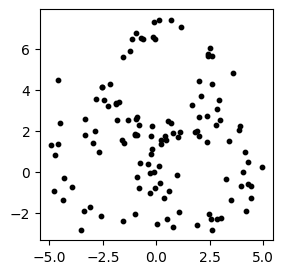

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.scatter(X[:,0], X[:,1], s=10, c="black")
plt.savefig("plots/sample_circles.png")

We have drawn a sample $X$ from a distribution around three circles.
Now we take another 10 samples from the same distribution and compute the prevalence of cycles. For each sample Y, there is a sequence $X \hookrightarrow Z \hookleftarrow Y$ where $Z=X\cup Y$.

In [127]:
%%capture
output_dir="output/"
IBloFunMatch_X = get_IBloFunMatch_subset(Dist_X, Dist_X, range(len(X)), attributes, types_list, output_dir)
X_barcode = IBloFunMatch_X["X_barcode"]
X_reps = IBloFunMatch_X["X_reps"]

In [160]:
def compute_prevalence(Dist_X, Dist_Y, Dist_Z):
    IBloFunMatch_XYZ = [
        get_IBloFunMatch_subset(Dist_X, Dist_Z, range(len(X)), attributes, types_list, output_dir),
        get_IBloFunMatch_subset(Dist_Y, Dist_Z, range(len(X), len(Z)), attributes, types_list, output_dir)
    ]
    common_entries = set.intersection(set(IBloFunMatch_XYZ[0]["induced_matching"]), set(IBloFunMatch_XYZ[1]["induced_matching"]))
    common_entries = np.array(list(common_entries))
    common_entries = list(common_entries[common_entries>=0])
    affinities_common = np.zeros(IBloFunMatch_XYZ[0]["S_barcode"].shape[0])
    for idx in common_entries:
        gamma = IBloFunMatch_XYZ[0]["S_barcode"][IBloFunMatch_XYZ[0]["induced_matching"].index(idx)]
        im_bar = IBloFunMatch_XYZ[0]["X_barcode"][idx]
        delta = IBloFunMatch_XYZ[1]["S_barcode"][IBloFunMatch_XYZ[1]["induced_matching"].index(idx)]
        C_gamdel = (min(gamma[1], delta[1]) - max(gamma[0], delta[0]))/(max(gamma[1], delta[1])- min(gamma[0], delta[0]))
        a_gamma = (im_bar[1]-gamma[0])/(gamma[1]-gamma[0])
        a_delta = (im_bar[1]-delta[0])/(delta[1]-delta[0])
        affinity = a_gamma*a_delta*C_gamdel
        affinities_common[IBloFunMatch_XYZ[0]["induced_matching"].index(idx)] = a_gamma*a_delta*C_gamdel
    # end for 
    return list(affinities_common)

In [179]:
%%capture
RandGen = np.random.default_rng(6)
num_resamples = 15
Dist_X = dist.squareform(dist.pdist(X))
affinities_resamples = []
for it_sample in range(num_resamples):
    Y = three_circles_distribution(0.8, 120, RandGen)
    Z = np.vstack((X, Y))
    Dist_Y = dist.squareform(dist.pdist(Y))
    Dist_Z = dist.squareform(dist.pdist(Z))
    affinities_resamples.append(compute_prevalence(Dist_X, Dist_Y, Dist_Z))

In [180]:
affinities_arr = np.vstack(affinities_resamples)
affinities_mean = affinities_arr.mean(axis=0)
affinities_mean

array([0.00000000e+00, 5.73317626e-03, 0.00000000e+00, 0.00000000e+00,
       6.96722897e-04, 0.00000000e+00, 2.50016348e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.87118278e-01,
       2.01009653e-03, 3.15333345e-01, 1.52371299e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.93072855e-01])

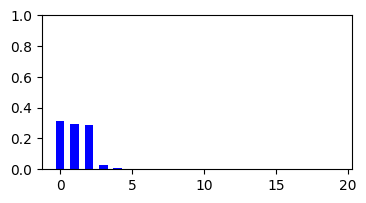

In [181]:
affinities_mean_sorted = affinities_mean[np.argsort(-affinities_mean)]
fig = plt.figure(figsize=(4,2))
plt.bar(range(len(affinities_mean_sorted)), affinities_mean_sorted, color="blue", width=0.6)
ax = plt.gca()
ax.set_ylim(0,1)
plt.savefig("plots/affinities_three_circles.png")

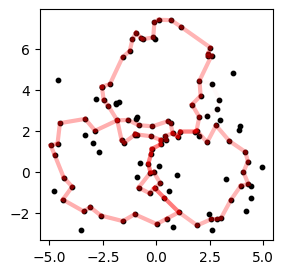

In [182]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.scatter(X[:,0], X[:,1], s=10, c="black")
for idx, affinity in enumerate(affinities_mean):
    cycle_rep = list(IBloFunMatch_X["S_reps"][idx])
    while len(cycle_rep)>0:
        edge = X[[cycle_rep.pop(), cycle_rep.pop()]]
        ax.plot(edge[:,0], edge[:,1], linewidth=3, c="red", alpha=affinity)
plt.savefig("plots/sample_circles.png")

## Matching Affinities

Let us look now into matchings and their affinities. For this, consider a 